Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

In [3]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/main/data/'
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

# Module Project: Classification Metrics

This sprint, the module projects will focus on creating and improving a model for the Tanazania Water Pump dataset. Your goal is to create a model to predict whether a water pump is functional, non-functional, or needs repair.

Dataset source: [DrivenData.org](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/).

## Directions

The tasks for this project are as follows:

- **Task 1:** Use `wrangle` function to import training and test data.
- **Task 2:** Split training data into feature matrix `X` and target vector `y`.
- **Task 3:** Split training data into training and validation sets.
- **Task 4:** Establish the baseline accuracy score for your dataset.
- **Task 5:** Build `model`.
- **Task 6:** Calculate the training and validation accuracy score for your model.
- **Task 7:** Plot the confusion matrix for your model.
- **Task 8:** Print the classification report for your model.
- **Task 9:** Identify likely `'non-functional'` pumps in the test set.
- **Task 10:** Find likely `'non-functional'` pumps serving biggest populations.
- **Task 11 (`stretch goal`):** Plot pump locations from Task 10.

You should limit yourself to the following libraries for this project:

- `category_encoders`
- `matplotlib`
- `pandas`
- `pandas-profiling`
- `plotly`
- `sklearn`


# I. Wrangle Data

In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv')).set_index('id')

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv', index_col=('id'))
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

# Split train into train & val
#train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              #stratify=train['status_group'], random_state=42)

In [5]:
def wrangle(X):
    """Wrangle train, validate, and test sets in the same way"""
    
    # Prevent SettingWithCopyWarning
    X = X.copy()
    
    # About 3% of the time, latitude has small values near zero,
    # outside Tanzania, so we'll treat these values like zero.
    X['latitude'] = X['latitude'].replace(-2e-08, 0)
    
    # When columns have zeros and shouldn't, they are like null values.
    # So we will replace the zeros with nulls, and impute missing values later.
    # Also create a "missing indicator" column, because the fact that
    # values are missing may be a predictive signal.
    cols_with_zeros = ['longitude', 'latitude', 'construction_year', 
                       'gps_height', 'population']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
        X[col+'_MISSING'] = X[col].isnull()
            
    # Drop duplicate columns
    duplicates = ['quantity_group', 'payment_type']
    X = X.drop(columns=duplicates)
    
    # Drop recorded_by (never varies) and id (always varies, random)
    unusable_variance = ['recorded_by']
    X = X.drop(columns=unusable_variance)
    
    # Convert date_recorded to datetime
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
    
    # Extract components from date_recorded, then drop the original column
    X['year_recorded'] = X['date_recorded'].dt.year
    #X['month_recorded'] = X['date_recorded'].dt.month
    #X['day_recorded'] = X['date_recorded'].dt.day
    X = X.drop(columns='date_recorded')
    
    # Engineer feature: how many years from construction_year to date_recorded
    X['years'] = X['year_recorded'] - X['construction_year']
    X['years_MISSING'] = X['years'].isnull()
    
    # return the wrangled dataframe
    return X

**Task 1:** Using the above `wrangle` function to read `train_features.csv` and `train_labels.csv` into the DataFrame `df`, and `test_features.csv` into the DataFrame `X_test`.

In [6]:
df = wrangle(train)
X_test = wrangle(test)

# II. Split Data

**Task 2:** Split your DataFrame `df` into a feature matrix `X` and the target vector `y`. You want to predict `'status_group'`.

**Note:** You won't need to do a train-test split because you'll use cross-validation instead.

In [7]:
target = 'status_group'
y = df[target]
features = df.columns.drop([target])
X = df[features]
print(X.shape)
print(y.shape)

(59400, 43)
(59400,)


**Task 3:** Using a randomized split, divide `X` and `y` into a training set (`X_train`, `y_train`) and a validation set (`X_val`, `y_val`).

In [8]:
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size = 0.8, random_state = 42)

# III. Establish Baseline

**Task 4:** Since this is a **classification** problem, you should establish a baseline accuracy score. Figure out what is the majority class in `y_train` and what percentage of your training observations it represents.

In [9]:
baseline_acc = y_train.value_counts(normalize= True)
print('Baseline Accuracy Score:', baseline_acc)

Baseline Accuracy Score: functional                 0.542971
non functional             0.384091
functional needs repair    0.072938
Name: status_group, dtype: float64


# IV. Build Models

**Task 5:** Build and train your `model`. Include the transformers and predictor that you think are most appropriate for this problem.

In [18]:
from sklearn.pipeline import make_pipeline
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
model_rf = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    RandomForestClassifier(n_estimators=150, random_state=42, n_jobs=-1)
)
model_rf.fit(X_train, y_train);


# V. Check Metrics

**Task 6:** Calculate the training and validation accuracy scores for `model`.

In [21]:
from sklearn.metrics import accuracy_score
training_acc = model_rf.score(X_train, y_train)
y_pred = model_rf.predict(X_val)
val_acc = accuracy_score(y_val, y_pred)

print('Training Accuracy Score:', training_acc)
print('Validation Accuracy Score:', val_acc)

Training Accuracy Score: 0.9999789562289563
Validation Accuracy Score: 0.8112794612794613


**Task 7:** Plot the confusion matrix for your model, using your validation data.

**Note:** Since there are three classes in your target vector, the dimensions of your matrix will be 3x3.

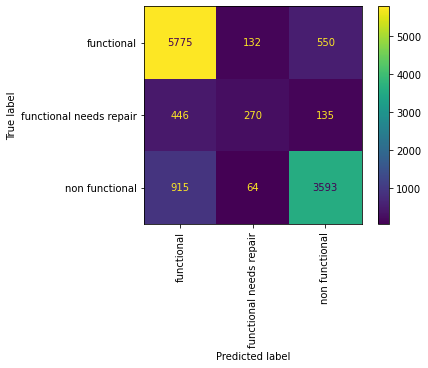

In [28]:
# Plot 3x3 confusion matrix
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(model_rf, X_val, y_val, values_format='.0f', xticks_rotation='vertical')

Calculating precision and recall for a multiclass problem is a bit of a mess. Fortunately, we can use `sklearn`'s classification report.

**Task 8:**  Print the classification report for your `model`, using your validation data.

In [31]:
# Print classification report 
from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred))

                         precision    recall  f1-score   support

             functional       0.81      0.89      0.85      6457
functional needs repair       0.58      0.32      0.41       851
         non functional       0.84      0.79      0.81      4572

               accuracy                           0.81     11880
              macro avg       0.74      0.67      0.69     11880
           weighted avg       0.80      0.81      0.80     11880



# VI. Tune Model

Usually, we use this part of the ML workflow to adjust the hyperparameters of the our model to increase performance based on metrics like accuracy. Today, we'll use it to help maximize the impact of our water pump repairs when resources are scarce. What if we only had funds to repair 100 water pumps?

(This activity is based on a [post](https://towardsdatascience.com/maximizing-scarce-maintenance-resources-with-data-8f3491133050) by Lambda alum Michael Brady.)

**Task 9:** Using your model's `predict_proba` method, identify the observations in your **test set** where the model is more than 95% certain that a pump is `'non-functional'`. Put these observations in the DataFrame `X_test_nf`.

In [35]:
random_inspections = 100
print(f'With {random_inspections} random inspections, we expect to repair {0.46*random_inspections} waterpumps')

#Identify the exact percentage that is non functionl
y_train = y_train != 'functional'
y_val = y_val != 'functional'
y_train.value_counts(normalize=True)

With 100 random inspections, we expect to repair 46.0 waterpumps


False    0.542971
True     0.457029
Name: status_group, dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


False    11865
True        15
dtype: int64

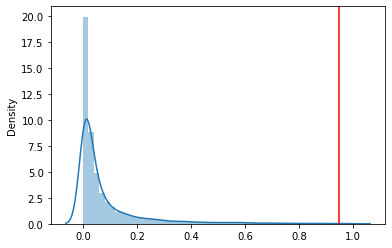

In [49]:
#make predicted probabilities into discreet prediction using a thresholsd
y_pred_proba = model_rf.predict_proba(X_val)[:,1]
threshold = 0.95
y_pred = y_pred_proba > threshold

ax = sns.distplot(y_pred_proba)
ax.axvline(threshold, color = 'red')
pd.Series(y_pred).value_counts()
                                             


In [66]:

X_test_nf = results = pd.DataFrame({'y_pred':y_pred,'y_pred_proba': y_pred_proba})
X_test_nf


,y_pred,y_pred_proba
0,False,0.040000
1,False,0.020000
2,False,0.066667
3,False,0.033333
4,False,0.006667
...,...,...
11875,False,0.006667
11876,False,0.093333
11877,False,0.000000
11878,False,0.080000


**Task 10:** Limit `X_test_nf` to the 100 pumps with the largest associated populations.

In [67]:
X_test_nf = X_test_nf.sort_values(by = 'y_pred_proba', ascending=False)
X_test_nf

,y_pred,y_pred_proba
5483,True,1.000000
10059,True,0.993333
11000,True,0.973333
8171,True,0.973333
478,True,0.973333
...,...,...
6515,False,0.000000
3750,False,0.000000
3751,False,0.000000
1674,False,0.000000


# VII. Communicate Results

**Task 11 (`stretch goal`):** Create a scatter plot with the location of the 100 pumps in `X_test_nf`.

**Note:** If you want to make this a **`super stretch goal`**, create a Mapbox scatter plot using [Plotly](https://plotly.github.io/plotly.py-docs/generated/plotly.express.scatter_mapbox.html).

In [71]:
import plotly.express as px
px.scatter(X_test_nf, x='y_pred_proba', y='y_pred', opacity=0.1)